# Extended DMD with control for nonlinear systems
We demonstrate extended dynamic mode decomposition for control (EDMDc) applied to the classical forced Van der Pol oscillator
(this is example in Sec. 4 in Korda & Mezić, _"Linear predictors for nonlinear dynamical systems: Koopman operator meets model predictive control"_, Automatica 2018), with dynamics given by:

$$\dot{x}_{1} = 2x_2 u,\\
\dot{x}_2 = -0.8x_1 + 2x_2 -10x_1^2x_2 + u$$

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
np.random.seed(42)  # for reproducibility

import warnings
warnings.filterwarnings('ignore')

import pykoopman as pk

Generating training data, where each trajectory starts at a random initial condition in the unit box $[-1,1]^2$ and is forced by a random control signal with values drawn from a uniform distribution over the interval $[-1,1]$.

In [112]:
n_states = 2 # Number of states
n_inputs = 1 # Number of control inputs
dT = 0.01    # Timestep

from pykoopman.common.examples import vdp_osc, rk4, square_wave

A training dataset is created consisting of 200 trajectories, each trajectory is integrated for 1000 timesteps and forced by a random actuation in the range $[-1,1]$.

In [113]:
n_traj = 200  # Number of trajectories
n_int = 1000  # Integration length
t = np.arange(0, n_int*dT, dT)

# Uniform forcing in [-1, 1]
u = 2*rnd.random([n_int, n_traj])-1

# Uniform distribution of initial conditions
x = 2*rnd.random([n_states, n_traj])-1

# Init
X = np.zeros((n_states, n_int*n_traj))
Y = np.zeros((n_states, n_int*n_traj))
U = np.zeros((n_inputs, n_int*n_traj))

# Integrate
for step in range(n_int):
    y = rk4(0, x, u[step, :], dT, vdp_osc)
    X[:, (step)*n_traj:(step+1)*n_traj] = x
    Y[:, (step)*n_traj:(step+1)*n_traj] = y
    U[:, (step)*n_traj:(step+1)*n_traj] = u[step, :]
    x = y

t = np.arange(0, n_int*dT, dT)

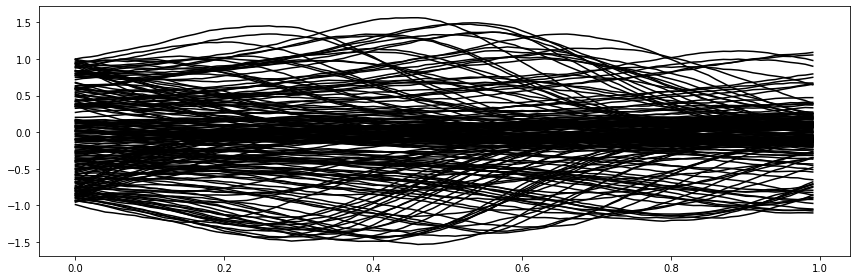

In [114]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
for traj_idx in range(n_traj):
    x = X[:, traj_idx::n_traj]
    axs.plot(t[0:100], x[1, 0:100], 'k')

In [115]:
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='gauss', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(x=X.T, y=Y.T, u=U.T)

Koopman(observables=RadialBasisFunction(centers=array([[-0.7712602 ,  0.08116391, -1.09928175, -0.4938513 , -0.94659796,
         0.2806932 ,  1.06131153, -1.10058965,  0.93620142,  0.62382521],
       [ 0.17825981,  1.56461218, -0.93088127, -1.5355701 ,  0.99751768,
        -1.26512792,  1.16563297,  1.45705332, -0.83537485,  1.26969393]])),
        regressor=EDMDc())

Compute inverse of training data using the estimated measurement matrix and calculate error:

In [116]:
print(np.linalg.norm((model.measurement_matrix() @ RBF.transform(X.T).T)-X)) # check inverse / measurement matrix

1.993576252635375e-12


### Compare prediction accuracy of Koopman model on a test trajectory

Describe example

In [117]:
n_int = 300  # Integration length
t = np.arange(0, n_int*dT, dT)
u = np.array([-square_wave(step+1) for step in range(n_int)])
x = np.array([0.5, 0.5])
# x = np.array([[-0.1], [-0.5]])

# Integrate nonlinear system
Xtrue = np.zeros((n_states, n_int))
Xtrue[:, 0] = x
for step in range(1, n_int, 1):
    y = rk4(0, Xtrue[:, step-1].reshape(n_states,1), u[np.newaxis, step-1], dT, vdp_osc)
    Xtrue[:, step] = y.reshape(n_states,)

Predict using Koopman model

In [118]:
# Multi-step prediction with Koopman/EDMDc model
Xkoop = model.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=n_int-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

Compare results

[0.5 0.5] [0.5 0.5]


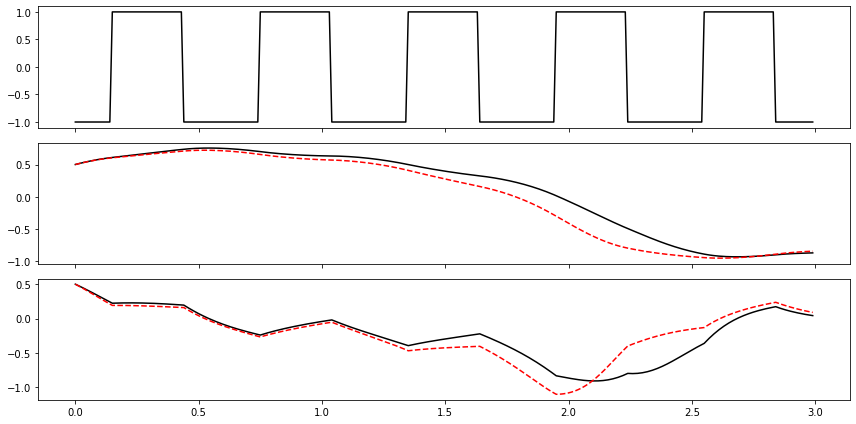

In [119]:
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(12, 6))
#sharey=True, gridspec_kw={'width_ratios': [2, 1]}
axs[0].plot(t, u, '-k')
# axs[0, 1].hist(u, bins=20, orientation="horizontal")
axs[1].plot(t, Xtrue[0, :], '-k')
axs[1].plot(t, Xkoop[:, 0], '--r')
axs[2].plot(t, Xtrue[1, :], '-k')
axs[2].plot(t, Xkoop[:, 1], '--r')
print(Xkoop[0,:], Xtrue[:,0])

In [120]:
print(Xkoop)

[[ 0.5         0.5       ]
 [ 0.50981114  0.48109147]
 [ 0.51923821  0.46160677]
 [ 0.5282705   0.44162484]
 [ 0.53689888  0.42122727]
 [ 0.54511585  0.40049693]
 [ 0.55291561  0.37951648]
 [ 0.56029396  0.35836705]
 [ 0.56724831  0.33712696]
 [ 0.57377759  0.3158706 ]
 [ 0.5798822   0.29466746]
 [ 0.58556384  0.27358143]
 [ 0.59082543  0.25267025]
 [ 0.59567099  0.23198514]
 [ 0.6001055   0.21157068]
 [ 0.60413476  0.19146482]
 [ 0.60796446  0.19146664]
 [ 0.61179311  0.19136059]
 [ 0.61561858  0.19114923]
 [ 0.61943878  0.19083527]
 [ 0.6232517   0.19042162]
 [ 0.62705537  0.18991131]
 [ 0.63084789  0.18930753]
 [ 0.63462742  0.18861358]
 [ 0.63839219  0.18783289]
 [ 0.64214051  0.18696899]
 [ 0.64587074  0.18602548]
 [ 0.64958133  0.18500605]
 [ 0.6532708   0.18391445]
 [ 0.65693774  0.18275447]
 [ 0.66058082  0.18152995]
 [ 0.6641988   0.18024473]
 [ 0.66779049  0.17890266]
 [ 0.6713548   0.17750761]
 [ 0.6748907   0.17606339]
 [ 0.67839726  0.17457382]
 [ 0.6818736   0.17304266]
 